In [122]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )

dir.create("pipeline/4.13.heart_failure/ridge", showWarnings = FALSE)


# Input CVPC + adult

In [123]:
metadata   =              fread("pipeline/3.1.covariates/metadata.txt"     , sep = "\t", header = TRUE , data.table = FALSE)
covariates = add_rownames(fread("pipeline/3.1.covariates/covariates.txt"   , sep = "\t", header = TRUE , data.table = FALSE))
int_list   = readLines         ("pipeline/3.2.eqtls/vars/cardiac_eqtls.txt")
#int_list   = int_list[grepl("^peer", int_list) == FALSE & grepl("^pc", int_list) == FALSE] # original
int_list   = c("sex", "total_reads_norm") # remove mitochondrial reads as covariate
covariates = covariates[,int_list]
gene_tpm   = add_rownames(fread("pipeline/1.2.expression/tpm_gene.normalized.txt"   , sep = "\t", header = TRUE , data.table = FALSE))
isof_tpm   = add_rownames(fread("pipeline/1.2.expression/tpm_isoform.normalized.txt", sep = "\t", header = TRUE , data.table = FALSE))
isof_use   = add_rownames(fread("pipeline/1.2.expression/use_isoform.normalized.txt", sep = "\t", header = TRUE , data.table = FALSE))


In [124]:

gene_info               = fread("input/phenotypes/gene_info.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
isof_info               = fread("input/phenotypes/isoform_info.txt", sep = "\t", header = TRUE, data.table = FALSE)
gene_info$transcript_id = gene_info$gene_id

diffgene = fread(paste("pipeline/4.1.differential_expression", "diffexp.txt"     , sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
diffcell = fread(paste("pipeline/4.1.differential_expression", "diffexp_cell.txt", sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)

diffgene$diffexp = FALSE
diffgene[diffgene$qval < 0.05, "diffexp"] = TRUE


# Input heart failure

In [125]:
meta4            = fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/input/phenotypes/SraRunTable_GSE46224.txt", sep = "\t", header = TRUE, data.table = FALSE)
colnames(meta4)  = tolower(gsub(" ", "_", colnames(meta4)))
meta4            = meta4[,c("run", "name", "age", "sex", "lvad_support")]
meta4$subject_id = gsub("_LVAD", "", meta4$name)

meta4 = meta4[!meta4$run %in% c("SRR830992", "SRR830976"),]
meta4$hf = 0
meta4[ meta4$lvad_support == "pre-LVAD", "hf"] = 1

gene_tpm_hf   = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/1.2.expression/tpm_gene.normalized.txt"  , sep = "\t", header = TRUE , data.table = FALSE))
isof_use_hf   = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/1.2.expression/use_isoform.expressed.txt", sep = "\t", header = TRUE , data.table = FALSE))

gene_tpm_hf   = gene_tpm_hf[,meta4$run]
isof_use_hf   = isof_use_hf[,meta4$run]

meta4       = meta4[ meta4$lvad_support != "nil",]
gene2sd     = data.frame(gene_id = rownames(gene_tpm_hf), sd = unlist(apply(gene_tpm_hf, 1, sd)), median = unlist(apply(gene_tpm_hf, 1, median)))
isof2sd     = data.frame(gene_id = rownames(isof_use_hf), sd = unlist(apply(isof_use_hf, 1, sd)), median = unlist(apply(isof_use_hf, 1, median)))
gene_tpm_hf = gene_tpm_hf[rownames(gene_tpm_hf) %in% gene2sd[ gene2sd$sd > 0, "gene_id"],]
isof_use_hf = isof_use_hf[rownames(isof_use_hf) %in% isof2sd[ isof2sd$sd > 0 & isof2sd$median > 0 & isof2sd$median < 100, "gene_id"],]

In [126]:
isof_use_hf["ENST00000261435.11_3",]

,SRR830989,SRR830990,SRR830991,SRR830993,SRR830994,SRR830995,SRR830996,SRR830973,SRR830974,SRR830975,⋯,SRR831003,SRR831004,SRR830981,SRR830982,SRR830983,SRR830984,SRR830985,SRR830986,SRR830987,SRR830988
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [127]:
cibersort_hf  = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/2.1.scrna_seq/cibersort.new.txt", sep = "\t", header = TRUE, data.table = FALSE))
flagstat_hf   = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/input/phenotypes/combined/flagstat.txt"  , sep = "\t", header = TRUE, data.table = FALSE))

cibersort_hf[,c("P-value", "Correlation", "RMSE")] = NULL
colnames(cibersort_hf) = gsub("_cell", "", colnames(cibersort_hf))
cell2color_hf          = data.frame(cell_type = colnames(cibersort_hf), color = c("#bb0000", "#00bb00", "#ff8888", "#FF34B3", "#0000bb", "#cdcd00", "#3D3D3D", "#8B814C")) 
cibersort_hf           = cibersort_hf[ meta4$run,]


covariates_hf = add_rownames(merge(cibersort_hf , flagstat_hf, by = "row.names"))
covariates_hf = add_rownames(merge(covariates_hf, meta4[,c("run", "sex", "age", "hf")], by.x = "row.names", by.y = "run"))
                                                        

covariates_hf$total_reads_norm                              = covariates_hf$total_reads / mean(covariates_hf$total_reads)
covariates_hf$uniquely_mapped_reads_to_canonical_chromsomes = rowSums(covariates_hf[,c("autosomal_reads", "chrX_reads", "chrY_reads")]) / covariates_hf$total_reads
covariates_hf$mitochondrial_reads                           = covariates_hf$chrM_reads / covariates_hf$total_reads

covariates_hf = covariates_hf[,c(cell2color_hf$cell_type, "total_reads_norm", "uniquely_mapped_reads_to_canonical_chromsomes", "mitochondrial_reads", "sex", "age")]

covariates_hf$sex = as.numeric(suppressMessages(mapvalues(covariates_hf$sex, from=c("male", "female"), to = 0:1)))


# Differential expression heart failure

In [128]:
suppressPackageStartupMessages(library(glmnet))
suppressPackageStartupMessages(library(hdi))



In [129]:
# Analysis
run_diffexp_ridge_lm = function(gene_id, x, covariates)
{
    covariates$exp = as.numeric(x[gene_id, rownames(covariates)])
    
    mylm = ridge.proj(x = as.matrix(covariates[, colnames(covariates) != "exp"]), y = covariates$exp, suppress.grouptesting = FALSE)
    out  = data.frame(transcript_id = gene_id, covariate = names(mylm$pval), beta = mylm$bhat, se = mylm$se, pval = mylm$pval)
    
    return(out)
}

run_diffexp = function(x, name, metadata, covariates)
{
	message(name)
    
	runs              = intersect(metadata$run, rownames(covariates))
	metadata          = metadata  [metadata$run %in% runs,]
	covariates        = covariates[runs,]
    covariates$tissue = 0
    
    covariates[metadata[metadata$hf == 1, "run"], "tissue"] = 1
    
	x                 = x[, rownames(covariates)]
	diffexp           = as.data.frame(rbindlist(lapply(rownames(x), function(gene_id){run_diffexp_ridge_lm(gene_id, x, covariates)})), stringsAsFactors = FALSE)
	diffexp$qval      = p.adjust(diffexp$pval, method = "bonferroni") 
    
	fwrite(diffexp, paste("pipeline/4.13.heart_failure/ridge", paste("diffexp", name, "ridge", "txt", sep = "."), sep = "/"), sep = "\t", col.names = TRUE, row.names = FALSE)
}

run_diffexp(gene_tpm_hf, "gene_tpm"   , meta4, covariates_hf)
#run_diffexp(isof_use_hf, "isoform_use", meta4, covariates_hf)


gene_tpm



In [135]:
gene_info               = fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/1.2.expression/gene_info.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
isof_info               = fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/1.2.expression/isoform_info.txt", sep = "\t", header = TRUE, data.table = FALSE)
gene_info$transcript_id = gene_info$gene_id

read_diffexp = function(name, gene_info)
{
    indata               = fread(paste("pipeline/4.13.heart_failure/ridge", paste("diffexp", name, "ridge", "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
    #indata$transcript_id = rownames(indata)
    indata               = indata[order(indata$pval),]
    indata               = merge(gene_info[,c("transcript_id", "gene_id", "gene_name", "gene_type")], indata)
    indata$qval          = p.adjust(indata$pval / length(unique(indata$covariate)), method = "bonferroni")
    indata$type          = name
    indata$diffexp       = FALSE
    
    if(nrow(indata[indata$qval < 0.05,]) > 0){indata[indata$qval < 0.05, "diffexp"] = TRUE}
    
    #message(paste(name, nrow(indata), nrow(indata[indata$qval < 0.05,])))
    return(indata)
}

indata_gene    = read_diffexp("gene_tpm"   , gene_info)
indata_iso_use = read_diffexp("isoform_use", isof_info)

diffexp = rbind(indata_gene, indata_iso_use)

fwrite(diffexp, "pipeline/4.13.heart_failure/ridge/diffexp.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


# differential expression plots

In [142]:
rbps = readLines("pipeline/rbps.txt")

In [136]:
diffexp_hf = diffexp
diffexp_de = fread("pipeline/4.15.differential_expression_ridge/diffexp.txt", sep = "\t", header = TRUE, data.table = FALSE)

**********************************
All genes

gene_tpm ipsc_cvpc heart 0.0911011543412073 1.77473843371903e-38

gene_tpm ipsc_cvpc arteria 0.107759975253272 3.21295599944449e-53

gene_tpm heart arteria -0.0737662780736226 9.03729565822602e-26

**********************************
RBPs

gene_tpm ipsc_cvpc heart 0.263084946714077 0.0035519172666054

gene_tpm ipsc_cvpc arteria 0.193720222311391 0.0332530400909859

gene_tpm heart arteria -0.235405779851193 0.00934359090048394



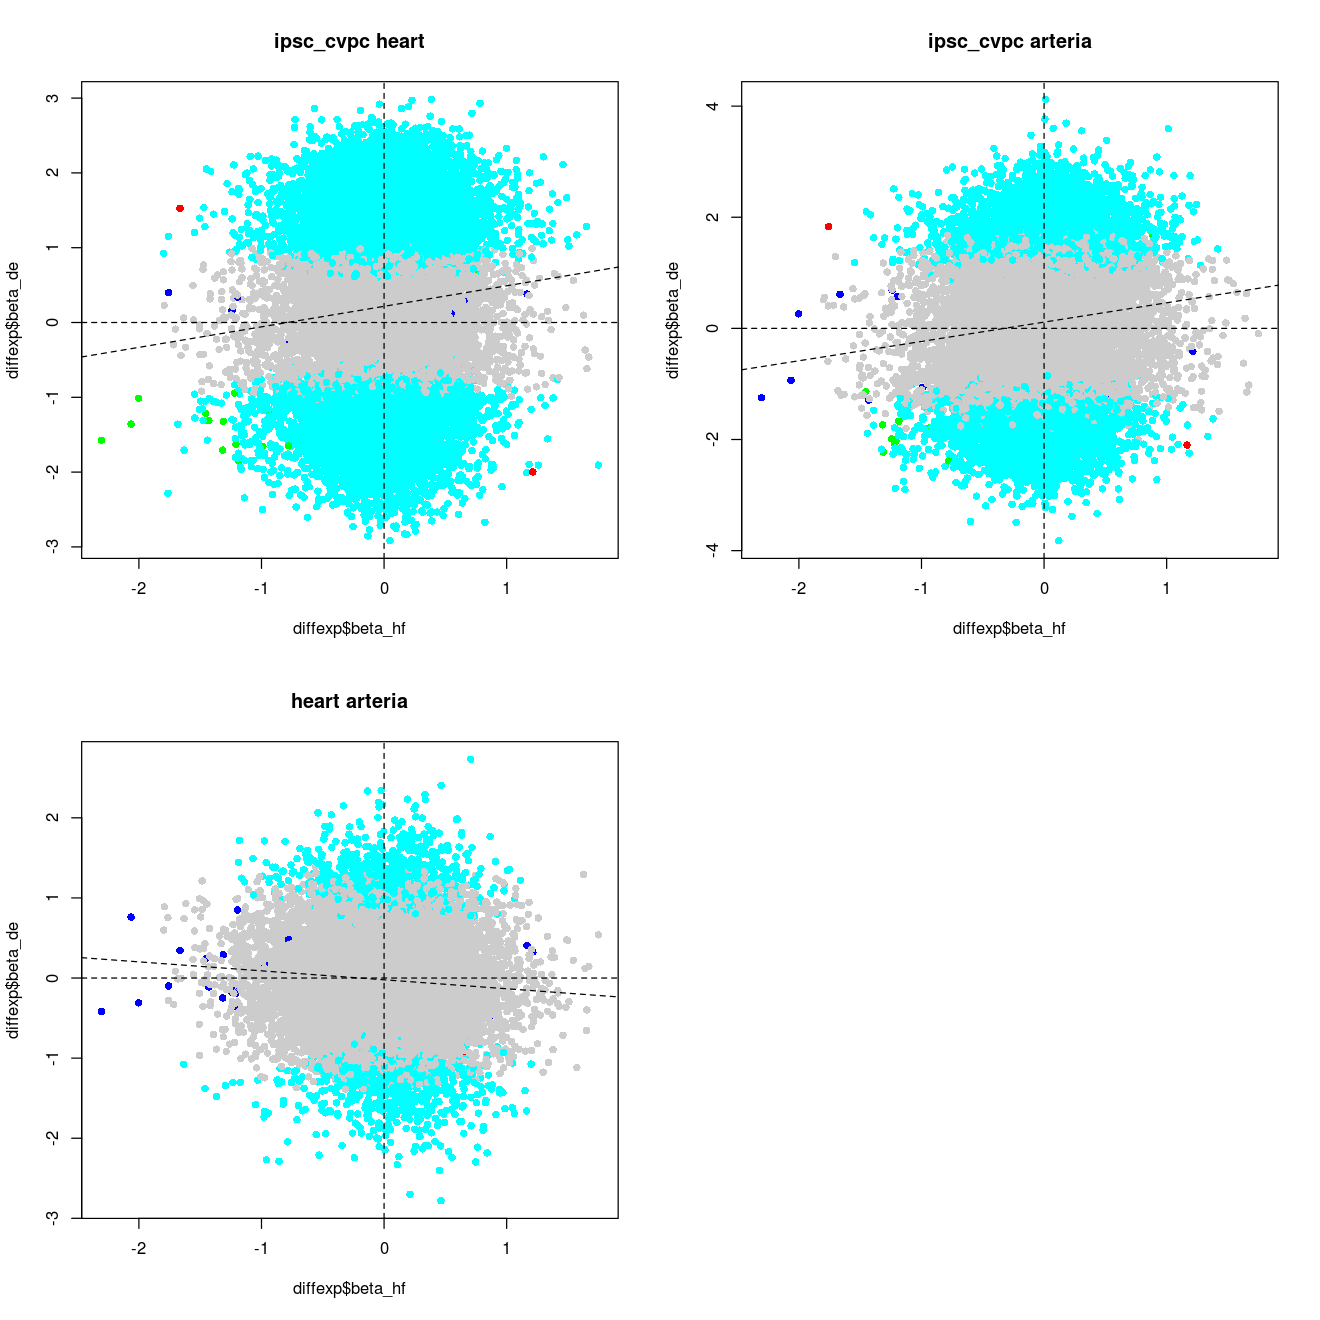

**********************************
Isoforms

isoform_use ipsc_cvpc heart 0.082947691321049 7.40406778214069e-45

isoform_use ipsc_cvpc arteria 0.110298219544357 3.99919165034198e-78

isoform_use heart arteria -0.0572512872175149 3.30541993263705e-22



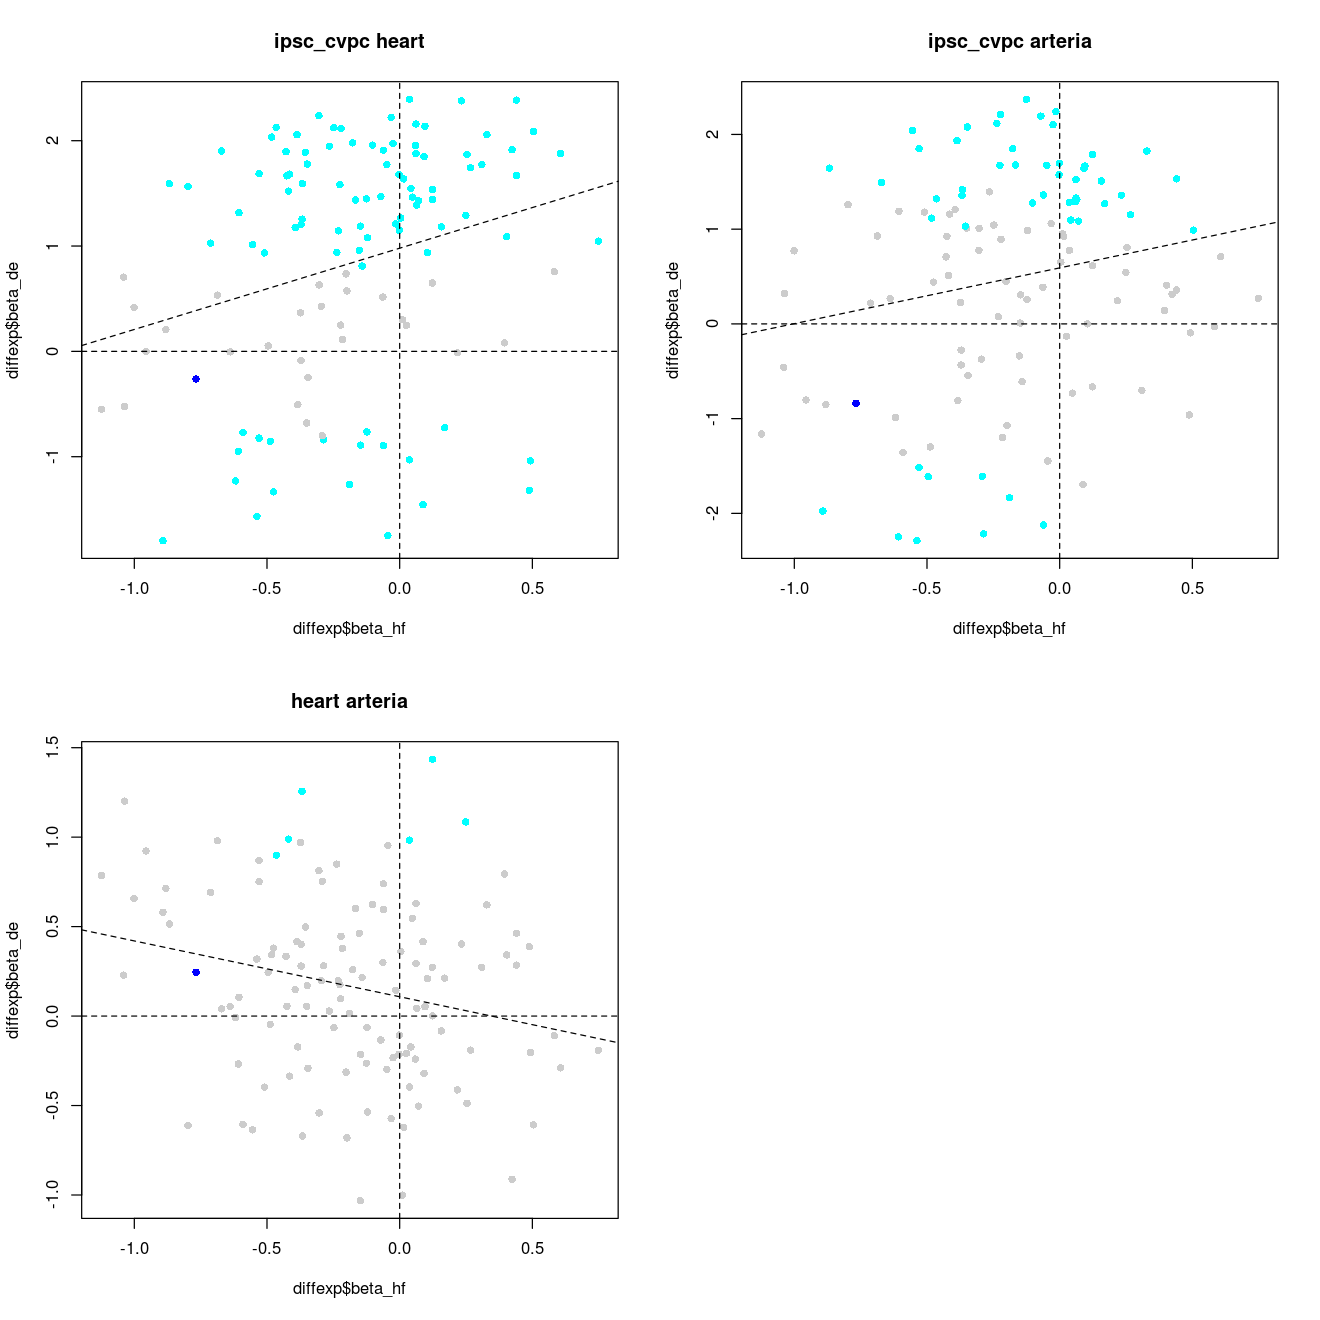

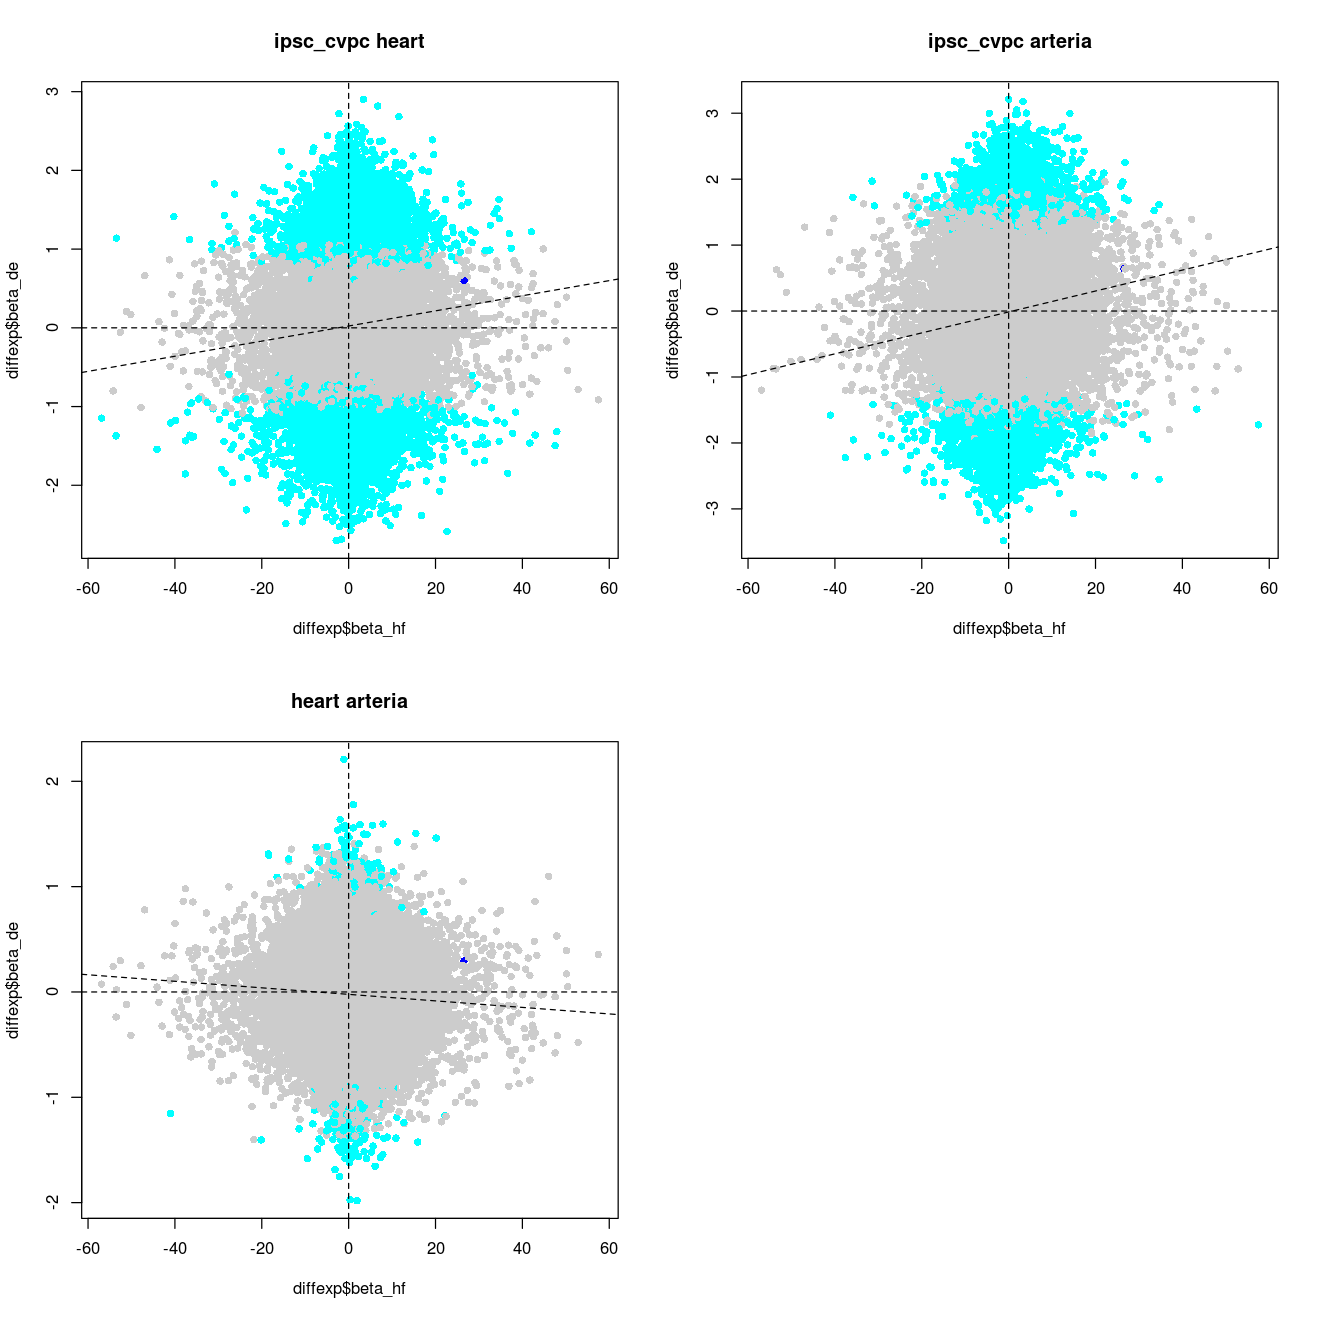

In [143]:
plot_diffexp = function(type, tissue1, tissue2, d1, d2)
{
    d1 = d1[ d1$type == type & d1$covariate == "tissue",]
    d2 = d2[ d2$type == type & d2$covariate == "tissue" & d2$tissue1 == tissue1 & d2$tissue2 == tissue2, ]
    
    diffexp = merge(d1[,c("transcript_id", "gene_id", "gene_name", "beta", "pval", "qval", "diffexp")],
                    d2[,c("transcript_id", "gene_id", "gene_name", "beta", "pval", "qval", "diffexp")],
                    by = c("transcript_id", "gene_id", "gene_name"),
                    suffixes = c("_hf", "_de")
                   )
    
    diffexp$color = "#cccccc"
    
    
    diffexp[ diffexp$diffexp_hf == TRUE  & diffexp$diffexp_de == TRUE  & sign(diffexp$beta_hf) == sign(diffexp$beta_de), "color"] = "#00ff00"
    diffexp[ diffexp$diffexp_hf == TRUE  & diffexp$diffexp_de == TRUE  & sign(diffexp$beta_hf) != sign(diffexp$beta_de), "color"] = "#ff0000"
    diffexp[ diffexp$diffexp_hf == TRUE  & diffexp$diffexp_de == FALSE, "color"] = "#0000ff"
    diffexp[ diffexp$diffexp_hf == FALSE & diffexp$diffexp_de == TRUE , "color"] = "#00ffff"
    diffexp[ diffexp$diffexp_hf == FALSE & diffexp$diffexp_de == FALSE, "color"] = "#cccccc"
    
    plot(diffexp$beta_hf, diffexp$beta_de, col = diffexp$color, pch = 16, main = paste(tissue1, tissue2))
    #plot(diffexp$log2r  , diffexp$beta_ridge, col = diffexp$color, pch = 16)
    
    abline(v = 0, lty = "dashed")
    abline(h = 0, lty = "dashed")
    abline(lm(beta_de ~ beta_hf, data = diffexp), lty = "dashed")
    
    mycor = cor.test(diffexp$beta_hf, diffexp$beta_de)
    
    #diffexp = diffexp[is.infinite(diffexp$log2r) == FALSE,]
    
    #mycor = cor.test(diffexp$log2r, diffexp$beta_ridge)
    
    message(paste(type, tissue1, tissue2, mycor$estimate, mycor$p.value))
    
    diffexp$sign = ""
    
    diffexp[diffexp$diffexp_hf == FALSE, "sign"] = "1-N.S."
    diffexp[diffexp$diffexp_hf == TRUE , "sign"] = "2-Stage-associated"
    
    diffexp[ diffexp$diffexp_hf == TRUE  & diffexp$diffexp_de == TRUE & sign(diffexp$beta_hf) == sign(diffexp$beta_de), "sign"] = "3-Same sign"
    diffexp[ diffexp$diffexp_hf == TRUE  & diffexp$diffexp_de == TRUE & sign(diffexp$beta_hf) != sign(diffexp$beta_de), "sign"] = "4-Different sign"
    
    #return(table(diffexp[,c("sign", "diffexp_de")]))
    
}

options(repr.plot.width = 11, repr.plot.height = 11)
layout(matrix(1:4, nrow = 2, byrow = TRUE))


message("**********************************\nAll genes")

plot_diffexp("gene_tpm"   , "ipsc_cvpc", "heart"  , diffexp_hf, diffexp_de)
plot_diffexp("gene_tpm"   , "ipsc_cvpc", "arteria", diffexp_hf, diffexp_de)
plot_diffexp("gene_tpm"   , "heart"    , "arteria", diffexp_hf, diffexp_de)
plot.new()
message("**********************************\nRBPs")
plot_diffexp("gene_tpm"   , "ipsc_cvpc", "heart"  , diffexp_hf[ diffexp_hf$gene_name %in% rbps,], diffexp_de)
plot_diffexp("gene_tpm"   , "ipsc_cvpc", "arteria", diffexp_hf[ diffexp_hf$gene_name %in% rbps,], diffexp_de)
plot_diffexp("gene_tpm"   , "heart"    , "arteria", diffexp_hf[ diffexp_hf$gene_name %in% rbps,], diffexp_de)
plot.new()
message("**********************************\nIsoforms")
plot_diffexp("isoform_use", "ipsc_cvpc", "heart"  , diffexp_hf, diffexp_de)
plot_diffexp("isoform_use", "ipsc_cvpc", "arteria", diffexp_hf, diffexp_de)
plot_diffexp("isoform_use", "heart"    , "arteria", diffexp_hf, diffexp_de)




In [138]:
diffexp_all = merge(diffexp_hf[diffexp_hf$covariate == "tissue",c("transcript_id", "gene_id", "gene_name", "type", "beta", "pval", "qval", "diffexp")],
                    diffexp_de[diffexp_de$covariate == "tissue",c("transcript_id", "gene_id", "gene_name", "type", "tissue1", "tissue2", "beta", "pval", "qval", "diffexp")],
                    by = c("transcript_id", "gene_id", "gene_name", "type"),
                    suffixes = c("_hf", "_de")
                   )

fwrite(diffexp_all, "pipeline/4.13.heart_failure/ridge/diffexp_vs_966.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [139]:
a = diffexp_all[ diffexp_all$diffexp_hf == TRUE & diffexp_all$diffexp_de == TRUE,]
a[order(a$beta_hf, decreasing = TRUE),]

,transcript_id,gene_id,gene_name,type,beta_hf,pval_hf,qval_hf,diffexp_hf,tissue1,tissue2,beta_de,pval_de,qval_de,diffexp_de
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
21910,ENSG00000144476.6_5,ENSG00000144476.6_5,ACKR3,gene_tpm,1.2133923,1.791519e-06,3.631589e-02,TRUE,ipsc_cvpc,heart,-1.9972455,5.338758e-54,1.088733e-49,TRUE
13091,ENSG00000119938.9_5,ENSG00000119938.9_5,PPP1R3C,gene_tpm,1.1661304,1.122022e-07,2.274452e-03,TRUE,ipsc_cvpc,arteria,-2.1002057,2.573200e-12,5.247527e-08,TRUE
3559,ENSG00000075975.16_4,ENSG00000075975.16_4,MKRN2,gene_tpm,0.8829342,8.492029e-07,1.721419e-02,TRUE,ipsc_cvpc,heart,1.1544064,9.465480e-21,1.930295e-16,TRUE
3561,ENSG00000075975.16_4,ENSG00000075975.16_4,MKRN2,gene_tpm,0.8829342,8.492029e-07,1.721419e-02,TRUE,ipsc_cvpc,arteria,1.6853586,2.665915e-14,5.436601e-10,TRUE
5088,ENSG00000090863.12_5,ENSG00000090863.12_5,GLG1,gene_tpm,0.7406167,7.156565e-08,1.450707e-03,TRUE,ipsc_cvpc,heart,0.7116079,4.996638e-10,1.018964e-05,TRUE
33736,ENSG00000174684.7_5,ENSG00000174684.7_5,B4GAT1,gene_tpm,0.6514777,2.198604e-06,4.456790e-02,TRUE,heart,arteria,-0.9212545,4.007081e-07,8.171639e-03,TRUE
7183,ENSG00000102870.6_5,ENSG00000102870.6_5,ZNF629,gene_tpm,0.4021642,1.842993e-07,3.735931e-03,TRUE,ipsc_cvpc,arteria,2.3714383,6.022748e-28,1.228219e-23,TRUE
7185,ENSG00000102870.6_5,ENSG00000102870.6_5,ZNF629,gene_tpm,0.4021642,1.842993e-07,3.735931e-03,TRUE,ipsc_cvpc,heart,1.3529284,3.692588e-59,7.530295e-55,TRUE
30589,ENSG00000168010.11_5,ENSG00000168010.11_5,ATG16L2,gene_tpm,-0.4530956,1.442970e-06,2.925045e-02,TRUE,ipsc_cvpc,heart,-0.6968332,3.750462e-08,7.648317e-04,TRUE


In [146]:
a = diffexp_all[ diffexp_all$diffexp_hf == TRUE & diffexp_all$gene_name %in% rbps,]
a[order(a$pval_hf, decreasing = FALSE),]

,transcript_id,gene_id,gene_name,type,beta_hf,pval_hf,qval_hf,diffexp_hf,tissue1,tissue2,beta_de,pval_de,qval_de,diffexp_de
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
12988,ENSG00000119707.14_5,ENSG00000119707.14_5,RBM25,gene_tpm,-0.7673808,3.467973e-07,0.007029928,TRUE,ipsc_cvpc,heart,-0.2626361,0.108701414,1,FALSE
12989,ENSG00000119707.14_5,ENSG00000119707.14_5,RBM25,gene_tpm,-0.7673808,3.467973e-07,0.007029928,TRUE,heart,arteria,0.2450826,0.253333681,1,FALSE
12990,ENSG00000119707.14_5,ENSG00000119707.14_5,RBM25,gene_tpm,-0.7673808,3.467973e-07,0.007029928,TRUE,ipsc_cvpc,arteria,-0.8377990,0.005722736,1,FALSE


In [149]:
a = diffexp_all[ diffexp_all$type == "gene_tpm" & diffexp_all$gene_name %in% rbps & diffexp_all$tissue1 == "",]
a[order(a$pval_hf, decreasing = FALSE),]



,transcript_id,gene_id,gene_name,type,beta_hf,pval_hf,qval_hf,diffexp_hf,tissue1,tissue2,beta_de,pval_de,qval_de,diffexp_de
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
12988,ENSG00000119707.14_5,ENSG00000119707.14_5,RBM25,gene_tpm,-0.7673808,3.467973e-07,0.007029928,TRUE,ipsc_cvpc,heart,-0.2626361475,1.087014e-01,1.000000e+00,FALSE
12989,ENSG00000119707.14_5,ENSG00000119707.14_5,RBM25,gene_tpm,-0.7673808,3.467973e-07,0.007029928,TRUE,heart,arteria,0.2450825861,2.533337e-01,1.000000e+00,FALSE
12990,ENSG00000119707.14_5,ENSG00000119707.14_5,RBM25,gene_tpm,-0.7673808,3.467973e-07,0.007029928,TRUE,ipsc_cvpc,arteria,-0.8377989791,5.722736e-03,1.000000e+00,FALSE
28579,ENSG00000164548.11_5,ENSG00000164548.11_5,TRA2A,gene_tpm,-0.9559485,2.182722e-04,1.000000000,FALSE,ipsc_cvpc,arteria,-0.8034163897,9.044716e-03,1.000000e+00,FALSE
28580,ENSG00000164548.11_5,ENSG00000164548.11_5,TRA2A,gene_tpm,-0.9559485,2.182722e-04,1.000000000,FALSE,heart,arteria,0.9223107652,1.123833e-04,1.000000e+00,FALSE
28581,ENSG00000164548.11_5,ENSG00000164548.11_5,TRA2A,gene_tpm,-0.9559485,2.182722e-04,1.000000000,FALSE,ipsc_cvpc,heart,-0.0001452816,9.993427e-01,1.000000e+00,FALSE
6052,ENSG00000100320.23_7,ENSG00000100320.23_7,RBFOX2,gene_tpm,0.5040814,1.003343e-03,1.000000000,FALSE,ipsc_cvpc,heart,2.0881773504,2.833573e-66,5.778505e-62,TRUE
6053,ENSG00000100320.23_7,ENSG00000100320.23_7,RBFOX2,gene_tpm,0.5040814,1.003343e-03,1.000000000,FALSE,heart,arteria,-0.6075583490,2.452435e-04,1.000000e+00,FALSE
6054,ENSG00000100320.23_7,ENSG00000100320.23_7,RBFOX2,gene_tpm,0.5040814,1.003343e-03,1.000000000,FALSE,ipsc_cvpc,arteria,0.9892376701,1.144068e-06,2.333099e-02,TRUE
